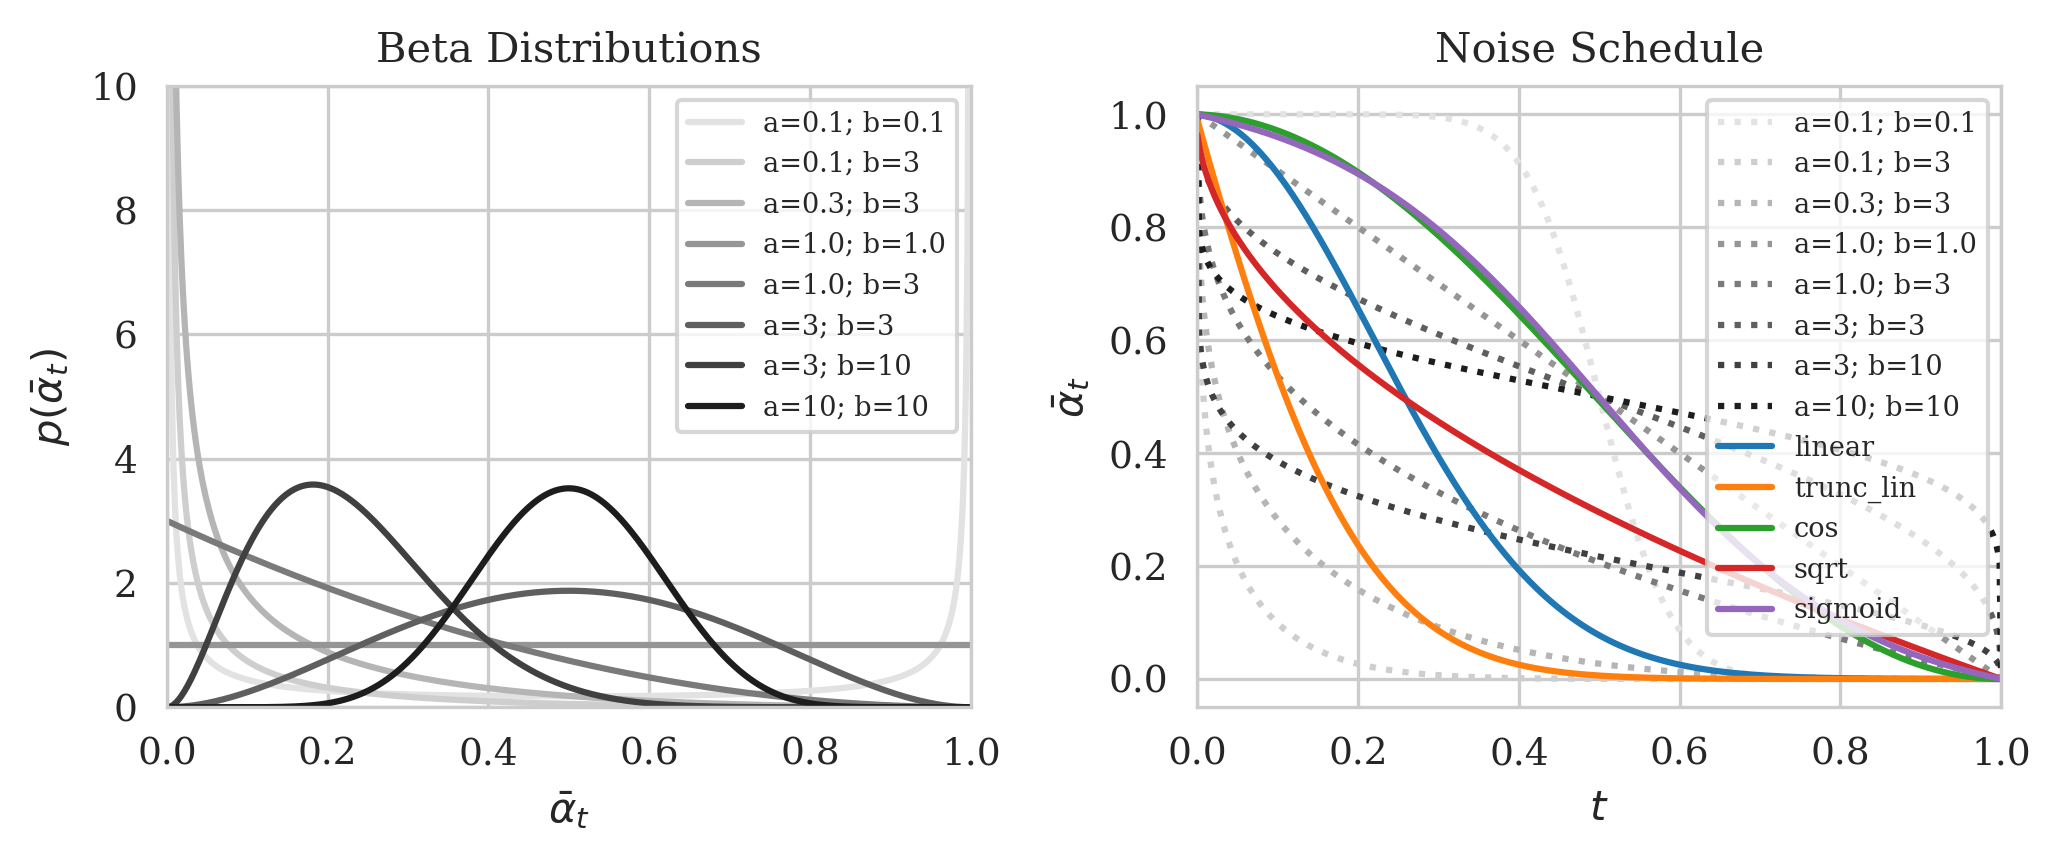

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import beta, cosine
import math
%matplotlib inline
# %matplotlib notebook
from matplotlib import rcParams

# 设置适合双排版论文的字体和图形尺寸
rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 6.5,
    "figure.figsize": (3.4, 2.5),  # 双栏论文的单栏宽度通常在3.4英寸左右
    "figure.dpi": 300,  # 提高分辨率
})

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    for i in range(num_diffusion_timesteps):  ## 2000
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)
betas_sqrt = betas_for_alpha_bar(500,lambda t: 1-np.sqrt(t + 0.0001))
alphas_cumprod_sqrt = np.cumprod(1-betas_sqrt, axis=0)
def beta_noise_schedule(timesteps, a=1.0, b=1.0):
    """
    Generate a noise schedule using Beta distribution, calculating alpha(s) and alphas_cumprod(s).
    
    Args:
    - timesteps (int): The total number of timesteps.
    - a (float): Alpha parameter for the Beta distribution.
    - b (float): Beta parameter for the Beta distribution.
    
    Returns:
    - alpha_schedule (np.ndarray): The alpha values for each timestep.
    - alphas_cumprod (np.ndarray): The cumulative alpha values for each timestep.
    """
    # Generate time steps from 0 to 1
    s = np.linspace(0, 1, timesteps+1)
    
    # Calculate alphas_cumprod(s) using beta.ppf(1 - s)
    alphas_cumprod = beta.ppf(1 - s, a, b)
    
    # Calculate alpha(s) = alphas_cumprod(s) / alphas_cumprod(s-1)
    # alpha_schedule = np.ones(timesteps)  # Initialize alpha schedule
    alpha_schedule = alphas_cumprod[1:] / alphas_cumprod[:-1]
    beta_schedule = 1- alpha_schedule
    # print(beta_schedule)
    return beta_schedule, alphas_cumprod[1:]
betas_beta,alphas_cumprod_beta = beta_noise_schedule(500)
# alphas_cumprod_beta = np.cumprod(1-betas_beta, axis=0)
def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1-(alphas_cumprod[1:] / alphas_cumprod[:-1])
    # print(betas.min())
    return np.clip(betas, 0, 0.999)
betas_cos = cosine_beta_schedule(500)
alphas_cumprod_cos = np.cumprod(1-betas_cos, axis=0)
# alphas_cumprod/=alphas_cumprod.mean()
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return np.linspace(beta_start, beta_end, timesteps)
betas_lin = linear_beta_schedule(500)
# print(betas_lin)
alphas_cumprod_lin = np.cumprod(1-betas_lin, axis=0)
def trunc_linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001 + 0.01
    beta_end = scale * 0.02 + 0.01
    if beta_end > 1:
        beta_end = scale * 0.001 + 0.01
    return np.linspace(beta_start, beta_end, timesteps, dtype=np.float64)
betas_trunc_lin = trunc_linear_beta_schedule(500)
alphas_cumprod_trunc_lin = np.cumprod(1-betas_trunc_lin,axis=0)
def sigmoid_beta_schedule(timesteps, start = -3, end = 3, tau = 1, clamp_min = 1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    better for images > 64x64, when used during training
    """
    def sigmoid(x):
        s = 1 / (1 + np.exp(-x))
        return s
    steps = timesteps + 1
    t = np.linspace(0, timesteps, steps) / timesteps
    v_start = sigmoid(start / tau)
    v_end = sigmoid(end / tau)
    alphas_cumprod = (-sigmoid((t * (end - start) + start) / tau) + v_end) / (v_end - v_start)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0, 0.999)
betas_sig = sigmoid_beta_schedule(500)
alphas_cumprod_sig = np.cumprod(1-betas_sig, axis=0)
# 定义 Beta 分布的参数
# params = [(0.1, 0.1), (0.1, 0.3), (0.1, 1.0), (0.1, 3), (0.1, 10), (0.3, 0.1), (0.3, 0.3), (0.3, 1.0), (0.3, 3), (0.3, 10), (1.0, 0.1), (1.0, 0.3), (1.0, 1.0), (1.0, 3), (1.0, 10), (3, 0.1), (3, 0.3), (3, 1.0), (3, 3), (3, 10), (10, 0.1), (10, 0.3), (10, 1.0), (10, 3), (10, 10)]
params = [(0.1, 0.1), (0.1, 3), (0.3, 3), (1.0, 1.0), (1.0, 3),  (3, 3), (3, 10), (10, 10)]
# params = [(0.3, 3)]
# 创建渐变的 colormap
# cmap_list = [plt.colormaps['Purples'],plt.colormaps['Greens'],plt.colormaps['Reds'],plt.colormaps['Greys']]  # 你可以选择其他 colormap，比如 'inferno', 'plasma', 'coolwarm' 等
cmap_grey =plt.colormaps['Greys']
# cmap_spectral = plt.colormaps['Spectral']
# 创建一个数值范围，用于映射颜色
# num_curves = 5  # 曲线数量
norm = mcolors.Normalize(vmin=0, vmax=10)  # 从 0 到 num_curves-1 映射到颜色

# # 创建一个 ScalarMappable 对象，能够根据 norm 和 cmap 映射颜色
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # 设置空数组，用于生成 colorbar


# 生成 gamma (γ) 的范围
gamma = np.linspace(0, 1, 500)

# 创建左侧图：Beta 分布
plt.figure(figsize=(7,3))

plt.subplot(1, 2, 1)
for index,(a, b) in enumerate(params):
    pdf = beta.pdf(gamma, a, b)
    plt.plot(gamma, pdf, label=f'a={a}; b={b}',color=cmap_grey(norm(params.index((a, b))+2)))
#     plt.plot(gamma, pdf, label=f'a={a}; b={b}',linestyle=':',color=cmap_grey(index))
# # plt.plot(gamma, cosine.pdf(gamma*math.pi/2),label='cosine', linestyle='--') # 添加余弦分布作为参考
plt.ylim((0, 10))
plt.xlim((0, 1))
plt.xlabel(r'$\bar{\alpha}_t$')
plt.ylabel(r'$p(\bar{\alpha}_t)$')
plt.title('Beta Distributions')
plt.legend()

# 创建右侧图：从均匀分布 s 映射到 γ 的变换函数
s = np.linspace(0, 1, 500)

plt.subplot(1, 2, 2)
for a,b in params:
    gamma_transformed = beta.ppf(1-s, a, b)
    # print(gamma[0],gamma[-1])
    # plt.plot(s,gamma_transformed,label=f'a={a}; b={b}',color=cmap_list[params.index((a, b))//3](norm(params.index((a, b))%3+4)))
    plt.plot(s,gamma_transformed,label=f'a={a}; b={b}',linestyle=':',color=cmap_grey(norm(params.index((a, b))+2)))
    # plt.plot(s,gamma_transformed,label=f'a={a}; b={b}',linestyle=':')
plt.plot(s,alphas_cumprod_lin, label='linear', linestyle='-') 
plt.plot(s,alphas_cumprod_trunc_lin, label='trunc_lin', linestyle='-')
plt.plot(s,alphas_cumprod_cos, label='cos', linestyle='-') # 添加余弦分布作为参考
# plt.plot(s,np.cos(((s)+0.008) / (1 + 0.008) * math.pi * 0.5) ** 2, label='cosine', linestyle='--') # 添加余弦分布作为参考
plt.plot(s,alphas_cumprod_sqrt, label='sqrt', linestyle='-') 
plt.plot(s,alphas_cumprod_sig,label='sigmoid',linestyle='-')
# plt.plot(s,alphas_cumprod_beta,label='beta',linestyle='-.')
# plt.plot(s,alphas_cumprod_trunc_lin,label='trunc_lin',linestyle='-')
plt.xlim((0, 1))
# plt.plot(s,betas_lin)
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
plt.xlabel(r'$t$')
plt.ylabel(r'$\bar{\alpha}_t$')
plt.title('Noise Schedule')
plt.legend()

plt.tight_layout()
plt.savefig('../imgs/beta.pdf',bbox_inches='tight')
plt.show()
plt.close()